In [2]:
!pip install bert-for-tf2
!pip install sentencepiece

In [3]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import pandas as pd
import re
import csv
import numpy as np
import math

In [4]:
print(tf.__version__)

2.4.1


In [5]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [6]:
train_all = pd.read_csv("all2.csv", delimiter = ",")
train_all.isnull().values.any()
train_all.shape

(6420, 3)

In [7]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:
articles = []
labels = []

with open("all2.csv", 'r', encoding = 'utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[2])
        #if(len(row)>13):
            #article = row[2]+row[3]+row[4]+row[5]+row[7]+row[13]
        #else:
        article = row[1]
        articles.append(preprocess_text(article))

print(len(articles))

6420


In [10]:
def tokenize_articles(txt):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(txt))

In [11]:
tokenized_articles = [tokenize_articles(article) for article in articles]
print(len(tokenized_articles))

6420


In [12]:
y = train_all['label']
y = np.array(list(map(lambda x: 1 if x=='real' else 0, y)))

print(y)

[1 1 0 ... 0 0 1]


In [13]:
input_with_len = [[tokenized_articles[i], y[i], len(tokenized_articles[i])]
                 for i in range(0, len(articles))]

In [14]:
input_with_len.sort(key=lambda x: x[2])
print(input_with_len[0])

[[16034, 8563, 21887, 23350], 0, 4]


In [15]:
import random

sorted_articles_labels = [(article_lab[0], article_lab[1]) for article_lab in input_with_len]
print(len(sorted_articles_labels))
print(sorted_articles_labels[0])
random.shuffle(sorted_articles_labels)

6420
([16034, 8563, 21887, 23350], 0)


In [55]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_articles_labels, output_types=(tf.int32, tf.int32))

In [56]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 56), dtype=int32, numpy=
 array([[19387, 14255,  2497, ...,     0,     0,     0],
        [ 2111,  5799,  2000, ...,     0,     0,     0],
        [ 2107,  2152,  2504, ...,     0,     0,     0],
        ...,
        [ 2678,  2038,  2042, ...,     0,     0,     0],
        [ 4954, 22328, 24667, ...,     0,     0,     0],
        [19387,  3005, 10464, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1])>)

In [57]:
TOTAL_BATCHES = math.ceil(len(sorted_articles_labels) / BATCH_SIZE)
print(TOTAL_BATCHES)
TEST_BATCHES = TOTAL_BATCHES // 20
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)
print(TEST_BATCHES)

201
10


In [58]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Bidirectional(LSTM(embedding_dimensions))
        self.pool = layers.GlobalMaxPool1D()

        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [59]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 10

In [60]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [61]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [62]:
text_model.fit(train_data, epochs=NB_EPOCHS)

Epoch 1/10
191/191 [==============================] - 216s 1s/step - loss: 0.4180 - accuracy: 0.7726
Epoch 2/10
191/191 [==============================] - 245s 1s/step - loss: 0.0816 - accuracy: 0.9708
Epoch 3/10
191/191 [==============================] - 236s 1s/step - loss: 0.0085 - accuracy: 0.9978
Epoch 4/10
191/191 [==============================] - 256s 1s/step - loss: 0.0023 - accuracy: 0.9996
Epoch 5/10
191/191 [==============================] - 264s 1s/step - loss: 9.9852e-04 - accuracy: 1.0000
Epoch 6/10
191/191 [==============================] - 237s 1s/step - loss: 4.5162e-04 - accuracy: 1.0000
Epoch 7/10
191/191 [==============================] - 217s 1s/step - loss: 1.3333e-04 - accuracy: 1.0000
Epoch 8/10
191/191 [==============================] - 268s 1s/step - loss: 2.7187e-05 - accuracy: 1.0000
Epoch 9/10
191/191 [==============================] - 268s 1s/step - loss: 2.0834e-05 - accuracy: 1.0000
Epoch 10/10
191/191 [==============================] - 271s 1s/step - l

In [63]:
results = text_model.evaluate(test_data)
print(results)

10/10 [==============================] - 3s 193ms/step - loss: 0.4523 - accuracy: 0.9156
[0.45231932401657104, 0.9156249761581421]


In [34]:
y_test = []
for element in test_data.as_numpy_iterator():
  y_test += element[1].tolist()

print(y_test[:5])

y_pred = text_model.predict(test_data)
y_pred = (y_pred > 0.5).astype('int').ravel().tolist()
y_pred[:5]

[1, 1, 1, 0, 0]


[1, 1, 1, 1, 0]

In [35]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#confusion_matrix(y_train_5, y_train_pred)
#print(prediction)
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

[[146  12]
 [ 11 151]]


In [36]:
print(metrics.classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       158
           1       0.93      0.93      0.93       162

    accuracy                           0.93       320
   macro avg       0.93      0.93      0.93       320
weighted avg       0.93      0.93      0.93       320



Text(69.0, 0.5, 'Truth')

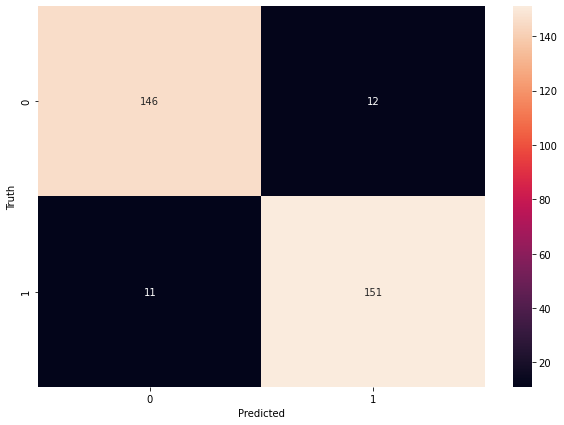

In [37]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sn.heatmap(matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')